In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/akshay/proj/ephys_analysis')

from myinit import *
from load_neural_data import *

from scipy.spatial.distance import cosine as cosdist
from scipy.optimize import minimize
from sklearn.metrics import log_loss
from collections import Counter
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['axes.titleweight'] = 'bold'

sns.set(font='Helvetica', style='ticks')
matplotlib.rcParams['text.color'] = [0,0,0]
sns.set_palette(sns.husl_palette(h=0.6))
colors = sns.color_palette()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [267]:
Counter(braindata['paul_240405-240416']['neuron_metadata']['brain_area'])

Counter({b'pIT': 183, b'V1': 107, b'V2': 84, b'cIT': 9})

In [2]:
braindata = load_from_hdf5('data/objaverse-shapenet-stylized_ephys-data_2024.h5')

## First plot individual neuron PSTHs

In [5]:
def np_groupby(resp_t, categories, agg=np.nanmean, eq_len = False):
    '''
        Group by the second dimension of resp_t, using the unique labels in categories.

        Arguments:
            - resp_t: shape (n_timepoints, n_images, n_neurons) or (n_images, n_neurons)
            - categories: shape = (n_images,)
    '''
    if len(resp_t.shape) == 2:
        resp_t = np.expand_dims(resp_t, axis=0)
    assert len(categories)==resp_t.shape[1], 'Size mismatch'
    unique_cats = np.unique(categories)  # all unique category labels
    # Initialize a np array to collect mean responses for each category
    resp_t_cat = np.zeros((resp_t.shape[0], len(unique_cats), resp_t.shape[2]))
    
    for ci, cat in enumerate(unique_cats):
        # Get the indices of images belonging to this category
        idxs = np.where(categories == cat)[0]

        if eq_len: idxs = np.random.choice(idxs, size=(len(unique_cats),), replace=True)
        
        # Slice out the responses for these images and take mean across images
        # resp_t[:, idxs, :] has shape (51, number_of_images_in_cat, 64)
        # Taking mean over axis=1 yields (51, 64)
        resp_t_cat[:, ci, :] = agg(resp_t[:, idxs, :], axis=1)
        
    return np.squeeze(resp_t_cat)


In [25]:

# categories = np.array(metadata['category'])  # shape (6426,)
# resp_t_cat = np_groupby(resp_t, categories)

# textures = np.array(metadata['texture'])
# resp_t_tex = np_groupby(resp_t, textures)

In [6]:
braindata.keys()

dict_keys(['anthony_20240117-20240419', 'baby1_20240117-20240419', 'baby1_240117-240419', 'jordan_20240117-20240121', 'louie_20240117-20240419', 'paul_20240405-20240416', 'paul_240405-240416', 'red_20240117-20240419', 'sweetie_20240117-20240419'])

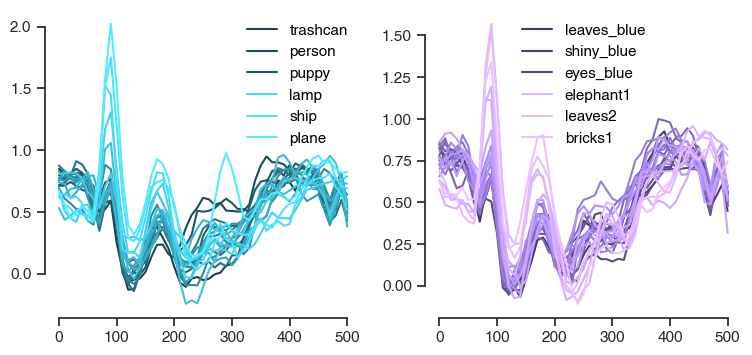

In [185]:
chI = 35
sess_name = 'louie_20240117-20240419'

resp_t = braindata[sess_name]['repavg']['response_temporal']
metadata = braindata[sess_name]['repavg']['stimulus_metadata']
time_windows = braindata[sess_name]['neuron_metadata']['temporal_windows']
ncsnr = braindata[sess_name]['neuron_metadata']['ncsnr']

fig, axes = plt.subplots(1,2,figsize=(9,4))
colors = sns.husl_palette(h=.6, n_colors=6)

for gi, group in enumerate(['category', 'texture']):
    resp_t_group = np_groupby(resp_t, np.array(metadata[group]))

    ax = axes[gi]
    ucats = np.unique(metadata[group])
    shifts = np.linspace(0.4, 1.4, len(ucats))#[::-1]
    sortorder = np.argsort(np.mean(resp_t_group[5:20, :, chI], axis=0))#[::-1]
    for ci, cat in enumerate(ucats):
        col = np.minimum(np.array(colors[gi])*shifts[ci], 1)
        ax.plot(time_windows, resp_t_group[:,sortorder[ci],chI], ls='-', color=col, label = ucats[sortorder[ci]].decode('utf-8') if (ci <3 or len(ucats)-ci<=3) else None)
    ax.legend(frameon=False)
sns.despine(trim=True)

In [180]:
np.argsort(ncsnr[::-1])

array([ 74,  60,  31, 103, 102,  34,  35, 101,  37, 100,  99,  41,  98,
        97,  71,  46,  47,  70,  96,  69,  68,  66,  93,  55,  56, 126,
        58, 104,  76, 105, 125, 124, 123,  84, 120, 119, 118,  83, 117,
        82,  12, 114, 115,  59, 106, 112, 111, 110, 109,  78, 107,  92,
       113,  38,  77, 122,  90,  23,  16,  72,  43,  61,  87,  75,  89,
        53,  27, 116,  63,  52,  48,  79,  54,  21,  51,  88,  22,  45,
        50,   4,  29,  91,   9,  30,  62,  95,  73,  65, 127,  57,  25,
       121,  49,   0,  36,  19,  17,  33,  81,   7,  85,  20,  32,  28,
        42,  67,  18,   8, 108,  24,  11,   5,   3,  26,  10,  14,  80,
        44,  13,  39,  40,   6,   2,  86,   1,  15,  94,  64])

2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


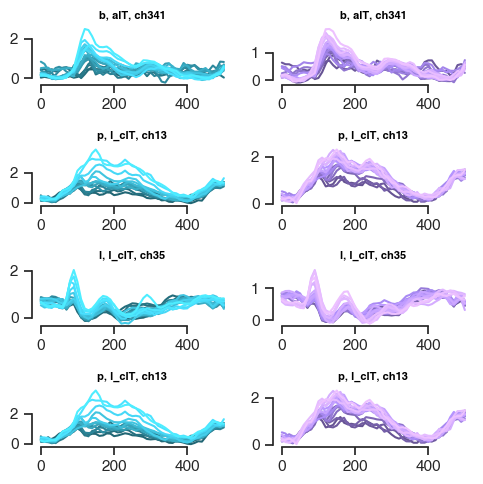

In [212]:
chI = 341
sess_name = 'baby1_240117-240419'

panels = [['baby1_240117-240419', 341,],
          ['paul_20240405-20240416', 13],
          ['louie_20240117-20240419', 35],
          ['paul_20240405-20240416', 13],
         ]
fig, axes = plt.subplots(4,2,figsize=(5,5))

for ai, [sess_name, chI] in enumerate(panels):
    resp_t = braindata[sess_name]['repavg']['response_temporal']
    metadata = braindata[sess_name]['repavg']['stimulus_metadata']
    time_windows = braindata[sess_name]['neuron_metadata']['temporal_windows']
    ncsnr = braindata[sess_name]['neuron_metadata']['ncsnr']
    area = braindata[sess_name]['neuron_metadata']['brain_area'][chI].decode('utf-8')
    
    colors = sns.husl_palette(h=.6, n_colors=6)
    
    for gi, group in enumerate(['category', 'texture']):
        resp_t_group = np_groupby(resp_t, np.array(metadata[group]))
    
        ax = axes[ai,gi]
        ucats = np.unique(metadata[group])
        shifts = np.linspace(0.6, 1.4, len(ucats))#[::-1]
        sortorder = np.argsort(np.mean(resp_t_group[5:20, :, chI], axis=0))#[::-1]
        for ci, cat in enumerate(ucats):
            col = np.minimum(np.array(colors[gi])*shifts[ci], 1)
            ax.plot(time_windows, resp_t_group[:,sortorder[ci],chI], ls='-', color=col, label = ucats[sortorder[ci]].decode('utf-8') if (ci <3 or len(ucats)-ci<=3) else None)
        # ax.legend(frameon=False)
        ax.set_title(f'{sess_name[0]}, {area}, ch{chI}', fontsize=8)
sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/paper_figures/psth_example_neurons.pdf', bbox_inches='tight', transparent=True)

In [206]:
area = braindata[sess_name]['neuron_metadata']['brain_area'][ncsnr>ncsnr_thresh]
from collections import Counter
area[0]

b'aIT'

2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


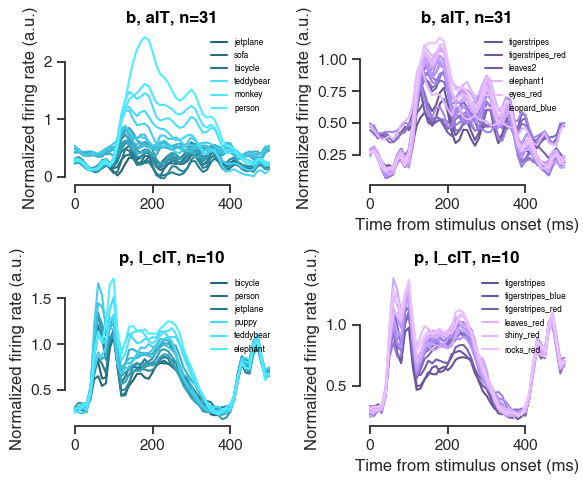

In [391]:
chI = 341
ncsnr_thresh = 0.4
sess_name = 'baby1_240117-240419'
panels = [['baby1_240117-240419', .4,],
          ['paul_20240405-20240416', .4],
         ]
fig, axes = plt.subplots(2,2,figsize=(6,5))
for pi, (sess_name, ncsnr_thresh)  in enumerate(panels):
    resp_t = braindata[sess_name]['repavg']['response_temporal']
    metadata = braindata[sess_name]['repavg']['stimulus_metadata']
    time_windows = braindata[sess_name]['neuron_metadata']['temporal_windows']
    ncsnr = braindata[sess_name]['neuron_metadata']['ncsnr']
    area = braindata[sess_name]['neuron_metadata']['brain_area'][0].decode('utf-8')
    colors = sns.husl_palette(h=.6, n_colors=6)
    
    for gi, group in enumerate(['category', 'texture']):
        resp_t_group = np_groupby(resp_t, np.array(metadata[group]))
    
        ax = axes[pi, gi]
        ucats = np.unique(metadata[group])
        shifts = np.linspace(0.6, 1.4, len(ucats))#[::-1]
        sortorder = np.argsort(np.mean(resp_t_group[5:20, :, ncsnr>ncsnr_thresh], axis=(0,2)))#[::-1]
        for ci, cat in enumerate(ucats):
            col = np.minimum(np.array(colors[gi])*shifts[ci], 1)
            ax.plot(time_windows, np.nanmean(resp_t_group[:,sortorder[ci],ncsnr>ncsnr_thresh], axis=-1), 
                    ls='-', color=col, label = ucats[sortorder[ci]].decode('utf-8') if (ci <3 or len(ucats)-ci<=3) else None)
        ax.set_ylabel('Normalized firing rate (a.u.)')
        if gi==1: ax.set_xlabel('Time from stimulus onset (ms)')
        ax.legend(frameon=False,prop={'size': 6})
    # if pi==0:
        axes[pi,gi].set_title(f'{sess_name[0]}, {area}, n={np.sum(ncsnr>ncsnr_thresh)}')
sns.despine(trim=True)
fig.tight_layout()
fig.savefig('figures/paper_figures/psth_meanarrays.pdf', bbox_inches='tight', transparent=True)

# Calculate tuning

In [7]:
from scipy.stats import f_oneway

def anova_fstat(resp, categories):
    """
    Compute ANOVA F-statistic and p-value for each neuron across categories.
    
    Parameters
    ----------
    resp : ndarray of shape (n_images, n_neurons)
        The neural responses.
    categories : array-like of shape (n_images,)
        Category label for each image.
        
    Returns
    -------
    Fvals : ndarray of shape (n_neurons,)
        F-statistic per neuron.
    Pvals : ndarray of shape (n_neurons,)
        p-value per neuron.
    """
    unique_cats = np.unique(categories)
    n_neurons = resp.shape[1]

    Fvals = np.zeros(n_neurons)
    Pvals = np.zeros(n_neurons)

    for n in range(n_neurons):
        # Gather data for each category
        groups = [resp[categories == cat, n] for cat in unique_cats]
        # Run ANOVA
        Fvals[n], Pvals[n] = f_oneway(*groups)

    return Fvals, Pvals

def selectivity_index(resp, categories):
    """
    Compute a simple Selectivity Index (SI) for each neuron, defined as:
       SI = (max - min) / (max + min)
    across the mean responses for each category.
    
    Parameters
    ----------
    resp : ndarray of shape (n_images, n_neurons)
        The neural responses.
    categories : array-like of shape (n_images,)
        Category label for each image.
        
    Returns
    -------
    si : ndarray of shape (n_neurons,)
        Selectivity index for each neuron.
    """
    # Group by category and compute the mean across images in each category
    # result shape => (n_categories, n_neurons)
    cat_means = np_groupby(resp, categories, agg=np.nanmean)

    # Calculate max and min across categories for each neuron
    max_vals = cat_means.max(axis=0)  # shape (n_neurons,)
    min_vals = cat_means.min(axis=0)  # shape (n_neurons,)

    # Compute SI
    eps = 1e-9
    si = (max_vals - min_vals) / (max_vals + min_vals + eps)

    return si

In [64]:
np.array(si_cat2)

(100, 128)

(7001, 128)

(7001, 128)

/tmp/ipykernel_542823/2897297489.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False)


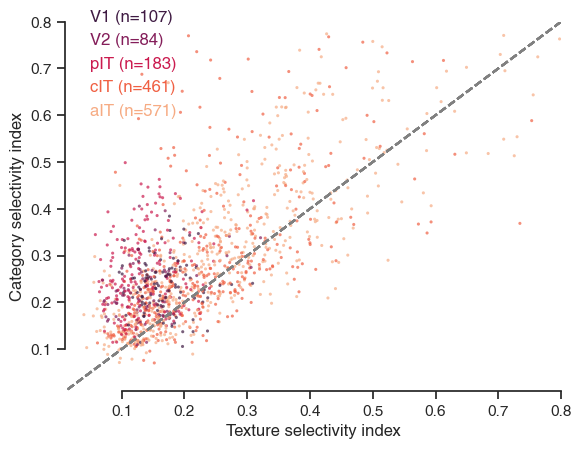

In [74]:
ncsnr_thresh = 0.2

def decode_utf(str_arr):
    return np.array(list(map(lambda x: x.decode('utf-8'), str_arr)))

def get_area_idx(areas):
    idx = []
    for area in areas:
        if 'V1' in area:
            idx.append(0)
        elif 'V2' in area:
            idx.append(1)
        elif 'pIT' in area:
            idx.append(2)
        elif 'cIT' in area:
            idx.append(3)
        elif 'aIT' in area:
            idx.append(4)
        else:
            raise f'Unknown area {area}'
    return np.array(idx)
            

fig, ax = plt.subplots()
colors = np.array(sns.color_palette("rocket", n_colors=5))
# sess = braindata['baby1_240117-240419']
areas_simple = np.array(['V1', 'V2', 'pIT', 'cIT', 'aIT'])
count = []
si_df = {'texture_si': [], 'category_si': [], 'area': [], 'subject': [], 'category_si_bs': [], 'texture_si_bs': []}
for si, sess_name in enumerate(braindata.keys()):
    sess = braindata[sess_name]
    resp = sess['repavg']['response_peak']
    metadata = sess['repavg']['stimulus_metadata']
    category = metadata['category']
    texture = metadata['texture']
    ncsnr = sess['neuron_metadata']['ncsnr']
    area = decode_utf(sess['neuron_metadata']['brain_area'])

    # Fvals_cat, Pvals_cat = anova_fstat(resp, category)
    # Fvals_tex, Pvals_tex = anova_fstat(resp, texture)
    si_cat_bs, si_tex_bs = [], []
    for _ in range(100):
        bootstrap_idx = np.random.randint(0, resp.shape[0], size=(resp.shape[0],))
        si_cat_bs.append(selectivity_index(resp[bootstrap_idx,:], category[bootstrap_idx]))
        si_tex_bs.append(selectivity_index(resp[bootstrap_idx,:], texture[bootstrap_idx]))

    si_cat = selectivity_index(resp, category)
    si_tex = selectivity_index(resp, texture)
    area_idx = get_area_idx(area)
    ax.scatter(si_tex, si_cat,  marker='.', s=20, linewidths=0, c=colors[area_idx], alpha=0.7)
    ax.plot([0,1], [0,1], '--', color='gray')
    count.append(areas_simple[area_idx])

    si_df['subject'].extend([sess_name.split('_')[0],]*len(si_cat))
    si_df['category_si'].extend(si_cat)
    si_df['texture_si'].extend(si_tex)
    si_df['category_si_bs'].extend(list(np.array(si_cat_bs).T))
    si_df['texture_si_bs'].extend(list(np.array(si_tex_bs).T))
    si_df['area'].extend(areas_simple[area_idx])
    
ax.legend(frameon=False)

for ai, area in enumerate(areas_simple):
    n=Counter(np.concatenate(count))[area]
    ax.text(0.05, 0.8-ai*.05, f'{area} ({n=})', color=colors[ai], )
    
ax.set_xlim(0.01, .8)
ax.set_ylim(0.01, .8)
ax.set_ylabel('Category selectivity index')
ax.set_xlabel('Texture selectivity index')
sns.despine(trim=True)


In [22]:
from scipy.stats import pearsonr

r, pval = pearsonr(si_df["texture_si"], si_df["category_si"])
print(f"r = {r:.3f}, p = {pval:.3e}")

r = 0.696, p = 4.413e-204

In [76]:
si_df = pd.DataFrame(si_df)

si_df

,texture_si,category_si,area,subject,category_si_bs,texture_si_bs
0,0.105312,0.150289,cIT,anthony,"[0.1936852689818238, 0.21500232250504947, 0.30...","[0.14613948426626788, 0.2197261171231015, 0.19..."
1,0.182916,0.181334,cIT,anthony,"[0.29030159165773833, 0.28750001597931085, 0.2...","[0.33309940884334727, 0.2379664516977541, 0.18..."
2,0.198317,0.222725,cIT,anthony,"[0.22098994210137976, 0.3464994334628555, 0.21...","[0.38398895374496744, 0.3138400120163254, 0.27..."
3,0.108857,0.151912,cIT,anthony,"[0.21827611428061464, 0.19970125900241478, 0.1...","[0.1567248209787812, 0.10183845136142508, 0.16..."
4,0.227305,0.264530,cIT,anthony,"[0.36438886471578646, 0.3393623741871377, 0.27...","[0.3271993864015237, 0.3227947697927643, 0.273..."
...,...,...,...,...,...,...
1401,0.194790,0.271440,aIT,sweetie,"[0.33018621038274243, 0.30645409015932434, 0.2...","[0.25690146428519806, 0.23066036939696455, 0.3..."
1402,0.369445,0.364390,aIT,sweetie,"[0.3990609772044643, 0.4053860820577928, 0.408...","[0.40863320912386075, 0.4376729113224932, 0.44..."
1403,0.177004,0.210644,aIT,sweetie,"[0.27073613149331294, 0.22152977623336725, 0.3...","[0.21441263409220615, 0.23413024030837662, 0.2..."
1404,0.237849,0.221622,aIT,sweetie,"[0.3545413824883153, 0.26117189846370675, 0.36...","[0.26224226088712416, 0.24907967882035156, 0.3..."


In [95]:
classifications = []
for idx, row in si_df.iterrows():
    cat_bs = np.array(row['category_si_bs'])
    tex_bs = np.array(row['texture_si_bs'])
    
    diff_bs = cat_bs - tex_bs
    lower_ci = np.percentile(diff_bs, 2.5)
    upper_ci = np.percentile(diff_bs, 97.5)

    if lower_ci > 0:
        classifications.append("more category selective")
    elif upper_ci < 0:
        classifications.append("more texture selective")
    else:
        classifications.append("not different")

si_df["classification"] = classifications

In [100]:
si_df.groupby('classification').count()

,texture_si,category_si,area,subject,category_si_bs,texture_si_bs
classification,,,,,,
more category selective,412,412,412,412,412,412
more texture selective,20,20,20,20,20,20
not different,974,974,974,974,974,974


In [102]:
si_df.groupby('classification').count() / len(si_df)

,texture_si,category_si,area,subject,category_si_bs,texture_si_bs
classification,,,,,,
more category selective,0.293030,0.293030,0.293030,0.293030,0.293030,0.293030
more texture selective,0.014225,0.014225,0.014225,0.014225,0.014225,0.014225
not different,0.692745,0.692745,0.692745,0.692745,0.692745,0.692745


2 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
'modified' timestamp seems very low; regarding as unix timestamp


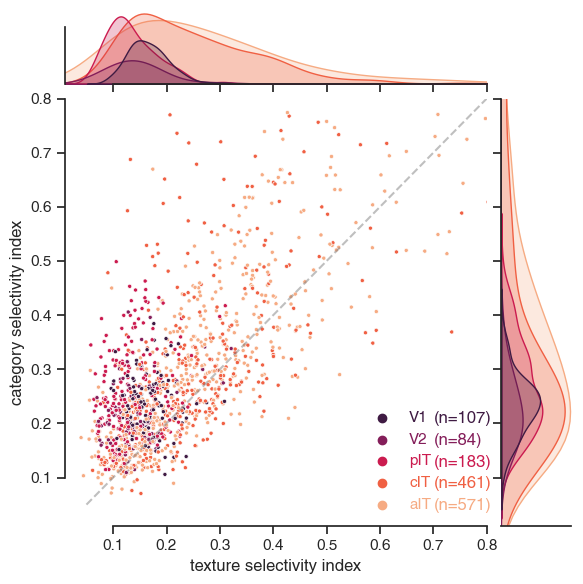

In [394]:
# fig, ax = plt.subplots()
colors = np.array(sns.color_palette("rocket", n_colors=5))

g = sns.jointplot(x='texture selectivity index', y='category selectivity index', hue='area', marker='.', 
                  hue_order = areas_simple, data = pd.DataFrame(si_df), palette='rocket')
g.ax_joint.plot([0.05,1], [0.05,1], '--', color='gray', alpha=0.5)
g.ax_joint.legend(frameon=False, loc=[.7, .02], labelcolor=colors)
g.ax_joint.set_xlim(0.01, .8)
g.ax_joint.set_ylim(0.01, .8)

for ai, area in enumerate(areas_simple):
    n=Counter(np.concatenate(count))[area]
    g.ax_joint.text(.7, .2-ai*.04, f'({n=})', color=colors[ai], )
    
sns.despine(trim=True)
g.fig.savefig('figures/paper_figures/category-vs-texture_tuning.pdf', bbox_inches='tight', transparent=True)

<Axes: xlabel='texture', ylabel='category'>

In [316]:
for si, sess_name in enumerate(braindata.keys()):
    sess = braindata[sess_name]
    area = decode_utf(sess['neuron_metadata']['brain_area'])
    print(sess_name, np.unique(get_area_idx(area)))

anthony_20240117-20240419 [5 6]

baby1_20240117-20240419 [6]

baby1_240117-240419 [5 6]

jordan_20240117-20240121 [6]

louie_20240117-20240419 [5]

paul_20240405-20240416 [5]

paul_240405-240416 [0 1 4 5]

red_20240117-20240419 [6]

sweetie_20240117-20240419 [5 6]

In [265]:
var20 = [np.nanvar(np.random.rand(20,)) for _ in range(100)]
var200 = [np.nanvar(np.random.rand(200,)) for _ in range(100)]


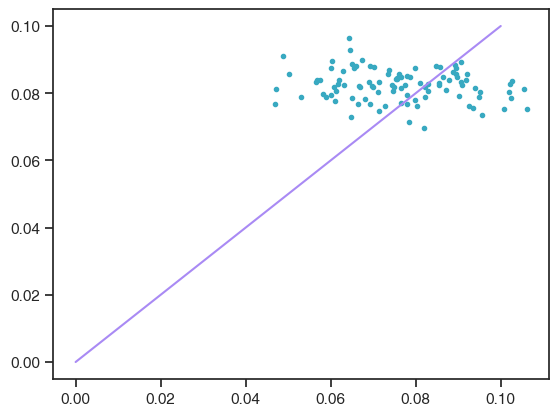

In [268]:
plt.plot(var20, var200, '.')
plt.plot([0, .1], [0, .1])

In [111]:
rows = []
for sess in tqdm(braindata):
    resp_peak = braindata[sess]['repavg']['response_peak']
    stim_name = braindata[sess]['repavg']['stimulus_name']
    texture = braindata[sess]['repavg']['stimulus_metadata']['texture']
    category = braindata[sess]['repavg']['stimulus_metadata']['category']
    brain_area = braindata[sess]['neuron_metadata']['brain_area']
    ncsnr = braindata[sess]['neuron_metadata']['ncsnr']
    
    n_images, n_neurons = resp_peak.shape
    for ii in range(n_images):
        for ni in range(n_neurons):
            rows.append({'monkey': sess.split('_')[0],
                         'image': stim_name[ii].decode('utf-8'), 
                         'neuron': f'{sess}_{ni}', 
                         'area': brain_area[ni].decode('utf-8').split('_')[-1], # get rid of l and r
                         'ncsnr': ncsnr[ni],
                         'response': resp_peak[ii,ni],
                         'texture': texture[ii],
                         'category': category[ii],
                        })
neural_df = pd.DataFrame(rows)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:10<00:00,  1.21s/it]


In [114]:
neural_df.groupby(['neuron', 'texture']).mean()

/tmp/ipykernel_542823/2165802944.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  neural_df.groupby(['neuron', 'texture']).mean()


ncsnr  response
neuron                       texture                              
anthony_20240117-20240419_0  b'bark1'                0.0  0.583043
                             b'bricks1'              0.0  0.600510
                             b'elephant1'            0.0  0.573715
                             b'eyes'                 0.0  0.521049
                             b'eyes_blue'            0.0  0.572145
...                                                  ...       ...
sweetie_20240117-20240419_99 b'shiny_blue'           0.0  0.568306
                             b'shiny_red'            0.0  0.520458
                             b'tigerstripes'         0.0  0.549441
                             b'tigerstripes_blue'    0.0  0.702296
                             b'tigerstripes_red'     0.0  0.587702

[28951 rows x 2 columns]

(3709300, 8)

In [170]:
def splithalf_spearmancorr(df):
    # Extract unique neuron info
    neuron_info = (
        df[["neuron", "ncsnr", "area", "monkey"]]
        .drop_duplicates(subset=["neuron"])
    )
    
    # Shuffle the rows
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Split into two halves
    half = len(df_shuffled) // 2
    df1 = df_shuffled.iloc[:half].copy()
    df2 = df_shuffled.iloc[half:].copy()

    for col in ['texture', 'category']: 
        # Compute mean response by (neuron, texture) in each half
        df1_mean = (df1.groupby(["neuron", col])["response"]
                       .mean()
                       .reset_index(name="mean_response_1"))
        df2_mean = (df2.groupby(["neuron", col])["response"]
                       .mean()
                       .reset_index(name="mean_response_2"))
        
        # Merge on neuron and texture
        merged = pd.merge(df1_mean, df2_mean, on=["neuron", col], how="inner")
        
        # For each neuron, compute Spearman’s correlation across textures
        spearman_corrs = merged.groupby("neuron").apply(
            lambda g: g["mean_response_1"].corr(g["mean_response_2"], method="spearman")
        )
        
        # Turn the groupby result into a DataFrame
        spearman_corrs = spearman_corrs.reset_index(name=f"{col}_spearmancorr")
    
        # Merge to attach correlation to each neuron's info
        neuron_info = pd.merge(neuron_info, spearman_corrs, on="neuron")

    return neuron_info


In [209]:
tuning_reliability = splithalf_spearmancorr(neural_df.copy())

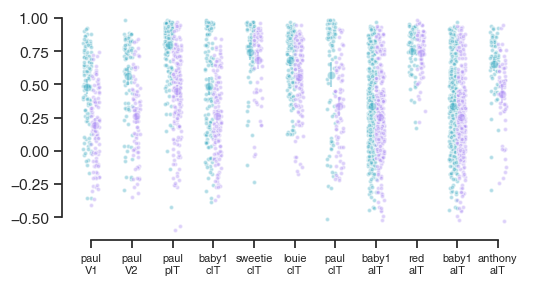

In [210]:
areas_simple = ['V1', 'V2', 'pIT', 'cIT', 'aIT', ]
fig, ax = plt.subplots(figsize=(6,3))
colors = sns.husl_palette(h=0.6, n_colors=6)

area_monkey = {'V1': ['paul'],
               'V2': ['paul'],
               'pIT': ['paul'],
               'cIT': ['baby1', 'sweetie', 'louie', 'paul'],
               'aIT': ['baby1', 'red', 'baby1', 'anthony']
              }
xi=0
xticklabels = []
for ai, area in enumerate(areas_simple):
    subset = tuning_reliability.loc[tuning_reliability.area == area]
    for mi, monkey in enumerate(area_monkey[area]):
        subsubset = subset.loc[subset.monkey==monkey]
        nChs = len(subsubset)
        ax.plot(xi-.1 + np.random.rand(nChs,)*0.2-.1, subsubset['category_spearmancorr'],
                '.', color=colors[0], alpha=0.4, markeredgecolor='white')
        ax.errorbar(xi-.1, np.nanmean(subsubset['category_spearmancorr']), yerr=SE(subsubset['category_spearmancorr']),
                    marker='o', color=colors[0], alpha=0.4, markeredgecolor='white')
        
        ax.plot(xi+.1 + np.random.rand(nChs,)*0.2-.1, subsubset['texture_spearmancorr'], 
                '.', color=colors[1], alpha=0.4, markeredgecolor='white')
        ax.errorbar(xi+.1, np.nanmean(subsubset['texture_spearmancorr']), yerr=SE(subsubset['texture_spearmancorr']),
                marker='o', color=colors[1], alpha=0.4, markeredgecolor='white')
    
        xi += 1
        xticklabels.append(f'{monkey}\n{area}')
ax.set_xticks(np.arange(xi), xticklabels, fontsize=8)
sns.despine(trim=True)

In [221]:
area_monkey = {'V1': ['paul'],
               'V2': ['paul'],
               'pIT': ['paul'],
               'cIT': ['baby1', 'sweetie', 'louie', 'paul'],
               'aIT': ['baby1', 'red', 'anthony']
              }
for ai, area in enumerate(area_monkey):
    print(area)
    for monkey in area_monkey[area]:
        print(monkey)
        subset = tuning_reliability.loc[(tuning_reliability.area == area)*(tuning_reliability.monkey==monkey)]
        
        t_stat_tex, p_val_tex = stats.ttest_1samp(subset["texture_spearmancorr"], 0)
        print(f"Texture correlation vs 0 (t-test): t = {t_stat_tex:.3f}, p = {p_val_tex:.3g}")
        
        # Test if category correlations are different from 0 (one-sample t-test)
        t_stat_cat, p_val_cat = stats.ttest_1samp(subset["category_spearmancorr"], 0)
        print(f"Category correlation vs 0 (t-test): t = {t_stat_cat:.3f}, p = {p_val_cat:.3g}")
    
    
        # Paired t-test
        t_stat, p_val_ttest = stats.ttest_rel(subset["texture_spearmancorr"], 
                                              subset["category_spearmancorr"])
        print(f"{area} {monkey}: Paired t-test: t-stat = {t_stat:.3f}, p-value = {p_val_ttest:.3g}")

V1

paul

Texture correlation vs 0 (t-test): t = 7.122, p = 1.33e-10

Category correlation vs 0 (t-test): t = 16.219, p = 1.76e-30

V1 paul: Paired t-test: t-stat = -9.961, p-value = 6.86e-17

V2

paul

Texture correlation vs 0 (t-test): t = 8.197, p = 2.64e-12

Category correlation vs 0 (t-test): t = 16.065, p = 3.37e-27

V2 paul: Paired t-test: t-stat = -8.291, p-value = 1.71e-12

pIT

paul

Texture correlation vs 0 (t-test): t = 19.328, p = 5.63e-46

Category correlation vs 0 (t-test): t = 49.279, p = 3.41e-107

pIT paul: Paired t-test: t-stat = -16.742, p-value = 1.09e-38

cIT

baby1

Texture correlation vs 0 (t-test): t = 9.900, p = 1.36e-17

Category correlation vs 0 (t-test): t = 14.005, p = 8.28e-28

cIT baby1: Paired t-test: t-stat = -8.108, p-value = 3.2e-13

sweetie

Texture correlation vs 0 (t-test): t = 21.209, p = 2.2e-30

Category correlation vs 0 (t-test): t = 22.623, p = 6.01e-32

cIT sweetie: Paired t-test: t-stat = -2.533, p-value = 0.0138

louie

Texture correlation vs 0 (t-test): t = 24.067, p = 3.76e-49

Category correlation vs 0 (t-test): t = 34.071, p = 9.71e-66

cIT louie: Paired t-test: t-stat = -6.142, p-value = 9.66e-09

paul

Texture correlation vs 0 (t-test): t = 8.853, p = 3.93e-13

Category correlation vs 0 (t-test): t = 11.679, p = 2.78e-18

cIT paul: Paired t-test: t-stat = -5.599, p-value = 3.69e-07

aIT

baby1

Texture correlation vs 0 (t-test): t = 14.738, p = 9.93e-38

Category correlation vs 0 (t-test): t = 17.849, p = 1.1e-49

aIT baby1: Paired t-test: t-stat = -5.045, p-value = 7.67e-07

red

Texture correlation vs 0 (t-test): t = 35.103, p = 4.48e-43

Category correlation vs 0 (t-test): t = 32.705, p = 3.08e-41

aIT red: Paired t-test: t-stat = -0.430, p-value = 0.669

anthony

Texture correlation vs 0 (t-test): t = 11.634, p = 2.46e-17

Category correlation vs 0 (t-test): t = 22.864, p = 3.31e-32

aIT anthony: Paired t-test: t-stat = -7.847, p-value = 6.61e-11

In [222]:
neural_df.

,monkey,image,neuron,area,ncsnr,response,texture,category
0,anthony,alarmclock_32b8dd2d96844c7db0fa0c5bf4a1214b_vi...,anthony_20240117-20240419_0,cIT,0.000000,2.033408,b'eyes',b'alarmclock'
1,anthony,alarmclock_32b8dd2d96844c7db0fa0c5bf4a1214b_vi...,anthony_20240117-20240419_1,cIT,0.000000,1.727817,b'eyes',b'alarmclock'
2,anthony,alarmclock_32b8dd2d96844c7db0fa0c5bf4a1214b_vi...,anthony_20240117-20240419_2,cIT,0.000000,-0.441678,b'eyes',b'alarmclock'
3,anthony,alarmclock_32b8dd2d96844c7db0fa0c5bf4a1214b_vi...,anthony_20240117-20240419_3,cIT,0.096325,0.096106,b'eyes',b'alarmclock'
4,anthony,alarmclock_32b8dd2d96844c7db0fa0c5bf4a1214b_vi...,anthony_20240117-20240419_4,cIT,0.000000,0.248171,b'eyes',b'alarmclock'
...,...,...,...,...,...,...,...,...
9174856,sweetie,tvmonitor-12_view-07.png,sweetie_20240117-20240419_123,aIT,0.000000,0.425667,b'orig',b'tvmonitor'
9174857,sweetie,tvmonitor-12_view-07.png,sweetie_20240117-20240419_124,aIT,0.000000,0.837409,b'orig',b'tvmonitor'
9174858,sweetie,tvmonitor-12_view-07.png,sweetie_20240117-20240419_125,aIT,0.000000,-0.165099,b'orig',b'tvmonitor'
9174859,sweetie,tvmonitor-12_view-07.png,sweetie_20240117-20240419_126,aIT,0.000000,0.980542,b'orig',b'tvmonitor'


In [243]:
from scipy.stats import spearmanr


In [252]:
xticklabels

21

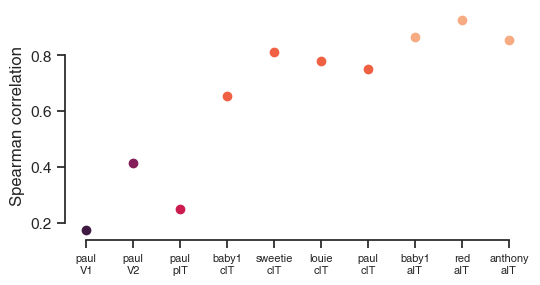

In [253]:
area_monkey = {'V1': ['paul'],
               'V2': ['paul'],
               'pIT': ['paul'],
               'cIT': ['baby1', 'sweetie', 'louie', 'paul'],
               'aIT': ['baby1', 'red', 'anthony']
              }
fig, ax = plt.subplots(figsize=(6,3))
xi=0
xticklabels = []
colors = sns.color_palette('rocket', n_colors=5)
for ai, area in enumerate(area_monkey):
    for monkey in area_monkey[area]:
        subset = neural_df.loc[(neural_df.monkey==monkey) & (neural_df.area==area)]
        tex_var = subset.groupby(['neuron', 'texture']).mean(numeric_only=True).reset_index().groupby(['neuron'])['response'].var().reset_index(name='tex_var')
        categ_var = subset.groupby(['neuron', 'category']).mean(numeric_only=True).reset_index().groupby(['neuron'])['response'].var().reset_index(name='categ_var')

        merge_df = pd.merge(tex_var, categ_var, on='neuron')

        res = spearmanr(merge_df['tex_var'], merge_df['categ_var'])
        # print(f'{monkey}: R={res.statistic:.3f}, p={res.pvalue:.6f}')
        
        ax.plot(xi, res.statistic, 'o', color=colors[ai])
        xi+=1
        xticklabels.append(f'{monkey}\n{area}')
ax.set_xticks(np.arange(xi), xticklabels, fontsize=8)
ax.set_ylabel('Spearman correlation')
sns.despine(trim=True)

In [255]:
area_monkey = {'V1': ['paul'],
               'V2': ['paul'],
               'pIT': ['paul'],
               'cIT': ['baby1', 'sweetie', 'louie', 'paul'],
               'aIT': ['baby1', 'red', 'anthony']
              }
for ai, area in enumerate(area_monkey):
    print(area)
    subset = neural_df.loc[(neural_df.area==area)]
    tex_var = subset.groupby(['neuron', 'texture']).mean(numeric_only=True).reset_index().groupby(['neuron'])['response'].var().reset_index(name='tex_var')
    categ_var = subset.groupby(['neuron', 'category']).mean(numeric_only=True).reset_index().groupby(['neuron'])['response'].var().reset_index(name='categ_var')

    merge_df = pd.merge(tex_var, categ_var, on='neuron')

    res = spearmanr(merge_df['tex_var'], merge_df['categ_var'])
    print(f'{area}: R={res.statistic:.3f}, p={res.pvalue:.6f}')
    
    for monkey in area_monkey[area]:
        subset = neural_df.loc[(neural_df.monkey==monkey) & (neural_df.area==area)]
        tex_var = subset.groupby(['neuron', 'texture']).mean(numeric_only=True).reset_index().groupby(['neuron'])['response'].var().reset_index(name='tex_var')
        categ_var = subset.groupby(['neuron', 'category']).mean(numeric_only=True).reset_index().groupby(['neuron'])['response'].var().reset_index(name='categ_var')

        merge_df = pd.merge(tex_var, categ_var, on='neuron')

        res = spearmanr(merge_df['tex_var'], merge_df['categ_var'])
        print(f'{monkey}: R={res.statistic:.3f}, p={res.pvalue:.6f}')


V1

V1: R=0.175, p=0.071142

paul: R=0.175, p=0.071142

V2

V2: R=0.414, p=0.000092

paul: R=0.414, p=0.000092

pIT

pIT: R=0.248, p=0.000717

paul: R=0.248, p=0.000717

cIT

cIT: R=0.790, p=0.000000

baby1: R=0.654, p=0.000000

sweetie: R=0.812, p=0.000000

louie: R=0.780, p=0.000000

paul: R=0.751, p=0.000000

aIT

aIT: R=0.854, p=0.000000

baby1: R=0.867, p=0.000000

red: R=0.928, p=0.000000

anthony: R=0.857, p=0.000000

/tmp/ipykernel_542823/807364735.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tex_var = subset.groupby(['neuron', 'texture']).mean().reset_index().groupby(['neuron'])['response'].var().reset_index(name='tex_var')
/tmp/ipykernel_542823/807364735.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  categ_var = subset.groupby(['neuron', 'category']).mean().reset_index().groupby(['neuron'])['response'].var().reset_index(name='categ_var')


,neuron,tex_var,categ_var
0,anthony_20240117-20240419_100,0.011063,0.015302
1,anthony_20240117-20240419_101,0.002564,0.009376
2,anthony_20240117-20240419_102,0.001933,0.005169
3,anthony_20240117-20240419_103,0.001362,0.006164
4,anthony_20240117-20240419_104,0.009281,0.018424
...,...,...,...
59,anthony_20240117-20240419_95,0.009923,0.012784
60,anthony_20240117-20240419_96,0.004259,0.012064
61,anthony_20240117-20240419_97,0.003306,0.012693
62,anthony_20240117-20240419_98,0.008229,0.020430


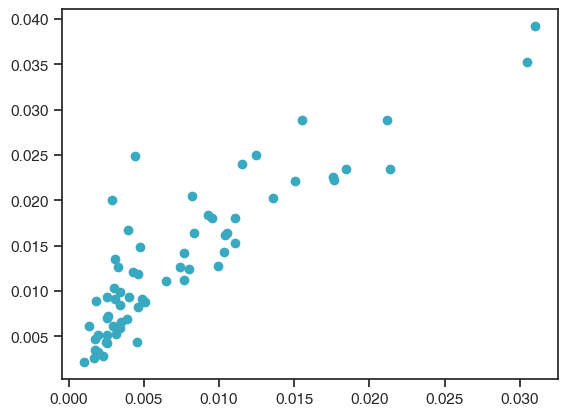